# Self-Driving Car Engineer Nanodegree


## Project: **Vehicle Detection and Tracking** 


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob, os, time
import pickle

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML


%matplotlib inline

## Training data

In [2]:
car_images = glob.glob('dataset/vehicles/**/*.png')
noncar_images = glob.glob('dataset/non-vehicles/**/*.png')

print("Total car images:", len(car_images))
print("Total non-car images:", len(noncar_images))



Total car images: 8792
Total non-car images: 8968


## Plot an  handful of data

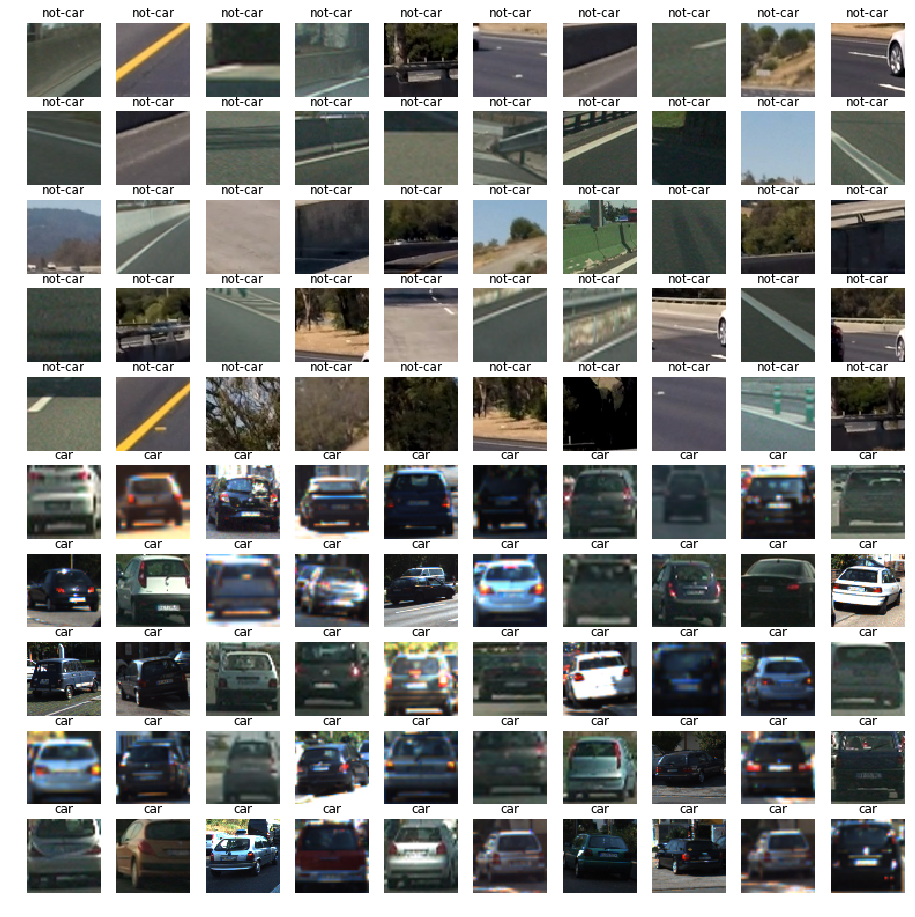

In [3]:
#reading in an image
fig, axs = plt.subplots(10,10, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.002)
axs = axs.ravel()


for i in np.arange(50):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('not-car', fontsize=12)    
    axs[i].imshow(img)
for i in np.arange(50,100):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=12)    
    axs[i].imshow(img)


## From a given image to Histogram of Oriented Gradients

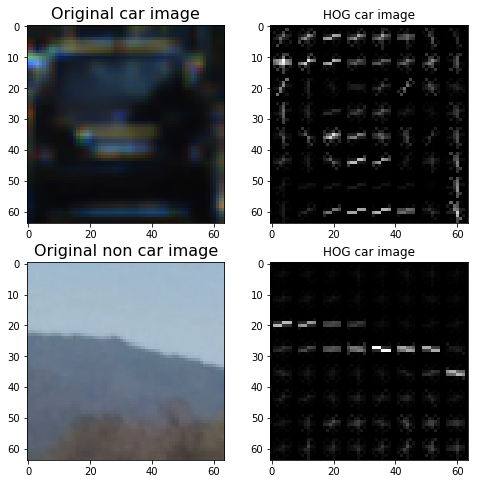

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

car_ind_sample_image = np.random.randint(0, len(car_images))
# Read in the image
car_sample_image = mpimg.imread(car_images[car_ind_sample_image])
car_gray = cv2.cvtColor(car_sample_image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
car_features, car_hog_image = get_hog_features(car_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

not_car_ind_sample_image = np.random.randint(0, len(noncar_images))
# Read in the image
noncar_sample_image = mpimg.imread(noncar_images[not_car_ind_sample_image])
noncar_gray = cv2.cvtColor(noncar_sample_image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
noncar_features, noncar_hog_image = get_hog_features(noncar_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (8,8))

ax1.set_title('Original car image', fontsize = 16)
ax1.imshow(car_sample_image, cmap = 'gray')
ax2.set_title('HOG car image')
ax2.imshow(car_hog_image, cmap = 'gray')

ax3.set_title('Original non car image', fontsize = 16)
ax3.imshow(noncar_sample_image, cmap = 'gray')
ax4.set_title('HOG car image')
ax4.imshow(noncar_hog_image, cmap = 'gray')

mpimg.imsave('./output_images/car_image.jpg', car_sample_image, cmap = 'gray')
mpimg.imsave('./output_images/car_hog_image.jpg', car_hog_image, cmap = 'gray')
mpimg.imsave('./output_images/non_car_image.jpg', noncar_sample_image, cmap = 'gray')
mpimg.imsave('./output_images/non_car_hog_image.jpg', noncar_hog_image, cmap = 'gray')


## Method to Extract Feaures by using Histogram of Oriented Gradients

In [7]:

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features




## Extract features

In [8]:
# Extraction Parameters

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))



141.19 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


## Train a classifier

In [11]:

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


3.96 Seconds to train SVC...
Test Accuracy of SVC =  0.982
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  1.  0.  1.  0.]
0.07411 Seconds to predict 10 labels with SVC


## Method to find cars through a classifier

In [12]:
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell            
                      
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles


## Draw boxes that contain a vehicle on a test image

In [13]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


6 rectangles found in image


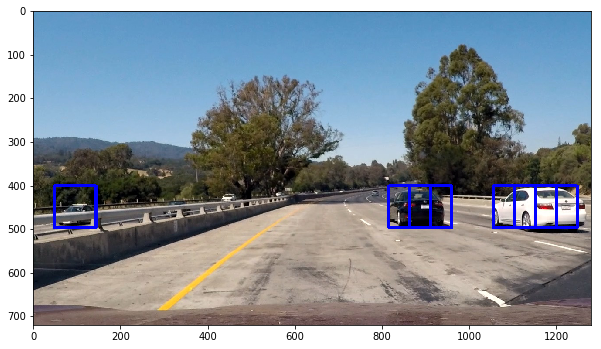

In [14]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 520
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')


test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

mpimg.imsave('./output_images/rect.jpg', test_img_rects)


## Potential Search areas

195 rectangles found in image


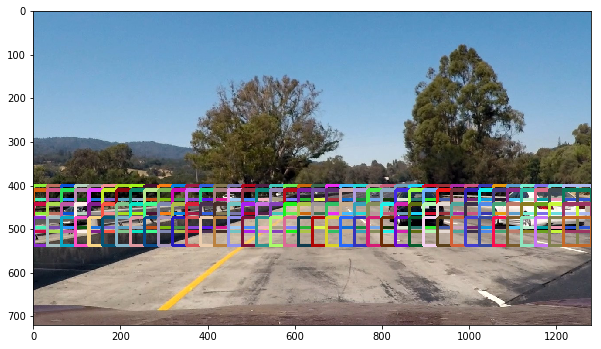

In [16]:
test_img = mpimg.imread('./test_images/test1.jpg')


colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

bxs = []

ystart = 400
ystop = 520
scale = 1.0



bxs.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))


ystart = 410
ystop = 540
scale = 1.0



bxs.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))


rectangles = [item for sublist in bxs for item in sublist] 


print(len(rectangles), 'rectangles found in image')


test_img_rects = draw_boxes(test_img, rectangles, color = 'random',)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

mpimg.imsave('./output_images/rect_1.jpg', test_img_rects)

50 rectangles found in image


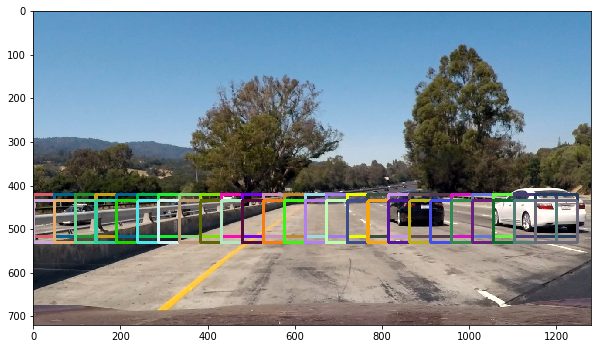

In [17]:
test_img = mpimg.imread('./test_images/test1.jpg')


colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

bxs = []

ystart = 420
ystop = 520
scale = 1.5



bxs.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))


ystart = 435
ystop = 565
scale = 1.5



bxs.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))


rectangles = [item for sublist in bxs for item in sublist] 


print(len(rectangles), 'rectangles found in image')


test_img_rects = draw_boxes(test_img, rectangles, color = 'random')
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

mpimg.imsave('./output_images/rect_2.jpg', test_img_rects)

19 rectangles found in image


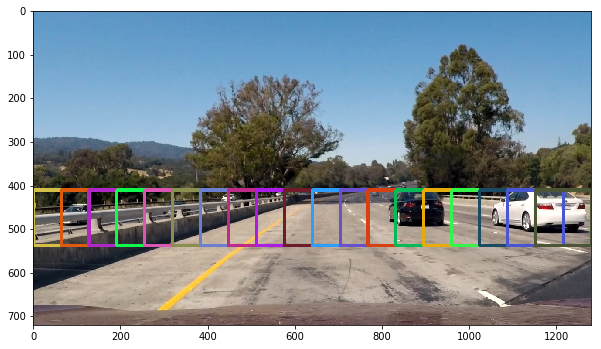

In [18]:
test_img = mpimg.imread('./test_images/test1.jpg')


colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

bxs = []

ystart = 400
ystop = 520
scale = 2



bxs.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))


ystart = 410
ystop = 550
scale = 2



bxs.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))


rectangles = [item for sublist in bxs for item in sublist] 


print(len(rectangles), 'rectangles found in image')


test_img_rects = draw_boxes(test_img, rectangles, color = 'random')
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

mpimg.imsave('./output_images/rect_3.jpg', test_img_rects)

45 rectangles found in image


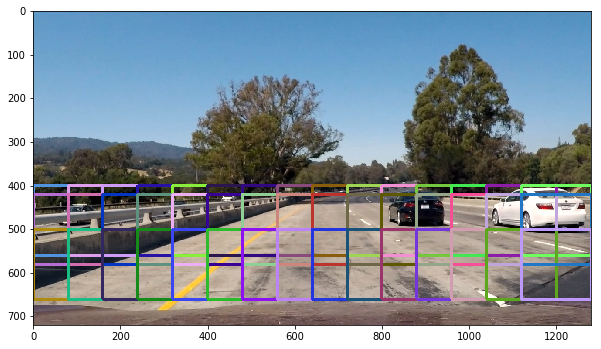

In [19]:
test_img = mpimg.imread('./test_images/test1.jpg')


colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

bxs = []

ystart = 400
ystop = 580
scale = 2.5



bxs.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))


ystart = 420
ystop = 670
scale = 2.5



bxs.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))


rectangles = [item for sublist in bxs for item in sublist] 


print(len(rectangles), 'rectangles found in image')


test_img_rects = draw_boxes(test_img, rectangles, color = 'random')
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

mpimg.imsave('./output_images/rect_4.jpg', test_img_rects)

## Combining different sizes of sliding windows

16 rectangles found in image


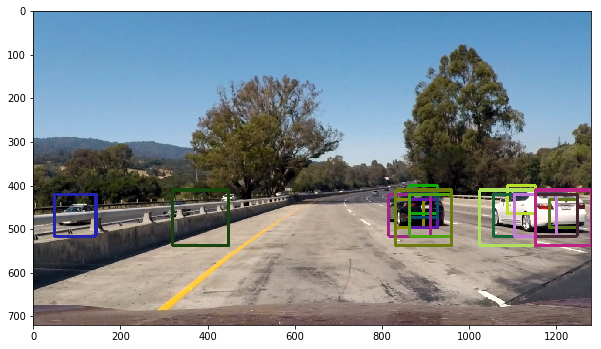

In [20]:
test_img = mpimg.imread('./test_images/test1.jpg')


colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

bxs = []

ystart = 400
ystop = 520
scale = 1.0



bxs.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))


ystart = 410
ystop = 540
scale = 1.0

bxs.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))



ystart = 420
ystop = 520
scale = 1.5

bxs.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))


ystart = 435
ystop = 565
scale = 1.5

bxs.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))


ystart = 400
ystop = 520
scale = 2

bxs.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))


ystart = 410
ystop = 550
scale = 2

bxs.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))


ystart = 400
ystop = 580
scale = 3.5

bxs.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))


ystart = 430
ystop = 670
scale = 2.5

bxs.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))


rectangles = [item for sublist in bxs for item in sublist] 


print(len(rectangles), 'rectangles found in image')


test_img_rects = draw_boxes(test_img, rectangles, color = 'random')
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

mpimg.imsave('./output_images/rect_5.jpg', test_img_rects)

## Heat Map

In [22]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap



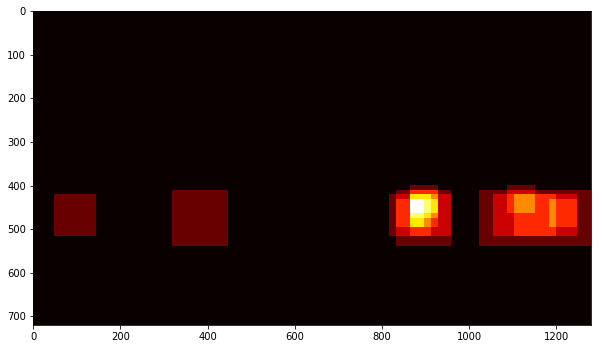

In [23]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

mpimg.imsave('./output_images/hot.jpg', heatmap_img, cmap='hot')


## Apply Threshold on Heat Map

In [24]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


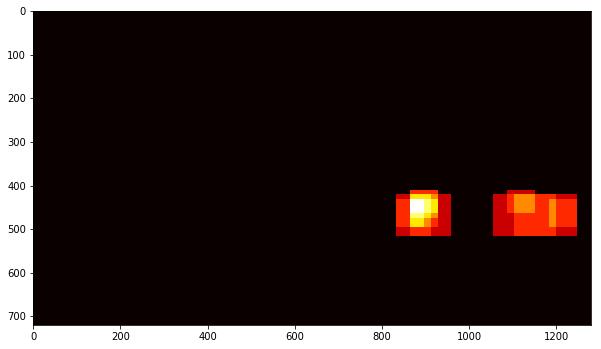

In [25]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

mpimg.imsave('./output_images/hot_fil.jpg', heatmap_img, cmap='hot')


## Labels

2 cars found


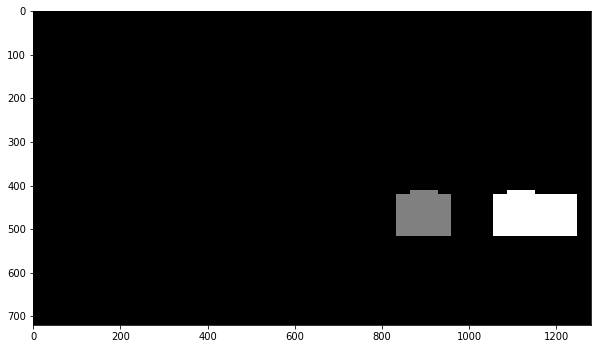

In [26]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

mpimg.imsave('./output_images/labels.jpg', labels[0],  cmap='gray')


## Draw bounding boxes for labels

In [28]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img, rects

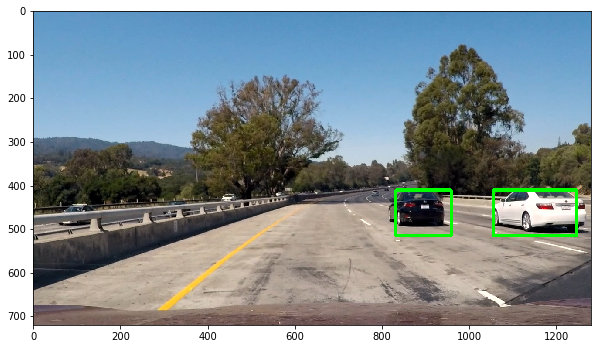

In [29]:
# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

mpimg.imsave('./output_images/test_1.jpg', draw_img)


## Pipeline for images

In [31]:
def process_image(img):
    
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    bxs = []

    ystart = 400
    ystop = 520
    scale = 1.0



    bxs.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))


    ystart = 410
    ystop = 540
    scale = 1.0

    bxs.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))



    ystart = 420
    ystop = 520
    scale = 1.5

    bxs.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))


    ystart = 435
    ystop = 565
    scale = 1.5

    bxs.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))


    ystart = 400
    ystop = 520
    scale = 2

    bxs.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))


    ystart = 410
    ystop = 550
    scale = 2

    bxs.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))


    ystart = 400
    ystop = 580
    scale = 3.5

    bxs.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))


    ystart = 430
    ystop = 670
    scale = 2.5

    bxs.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))


    rectangles = [item for sublist in bxs for item in sublist] 

    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img



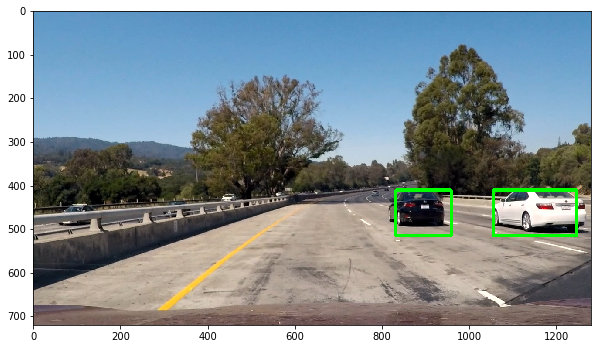

In [32]:
test_img = mpimg.imread('./test_images/test1.jpg')

draw_img = process_image(test_img)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

mpimg.imsave('./output_images/test_2.jpg', draw_img)

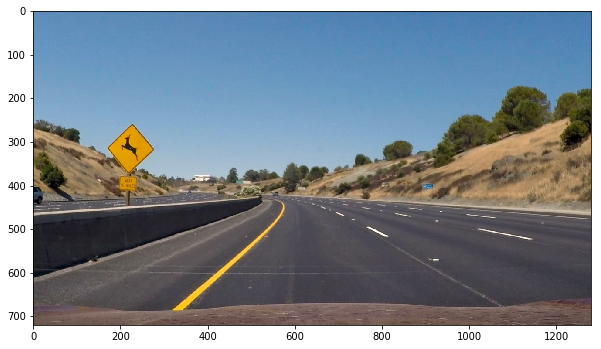

In [33]:
test_img = mpimg.imread('./test_images/test2.jpg')

draw_img = process_image(test_img)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

mpimg.imsave('./output_images/test_2.jpg', draw_img)

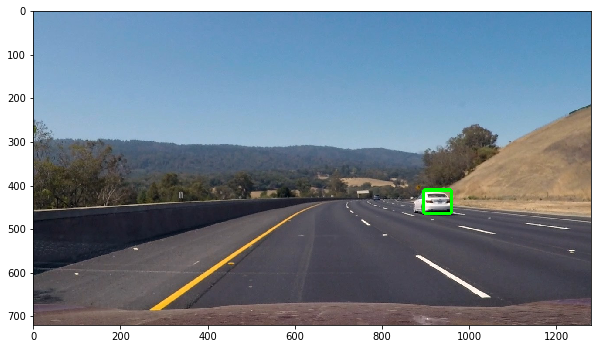

In [34]:
test_img = mpimg.imread('./test_images/test3.jpg')

draw_img = process_image(test_img)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

mpimg.imsave('./output_images/test_3.jpg', draw_img)

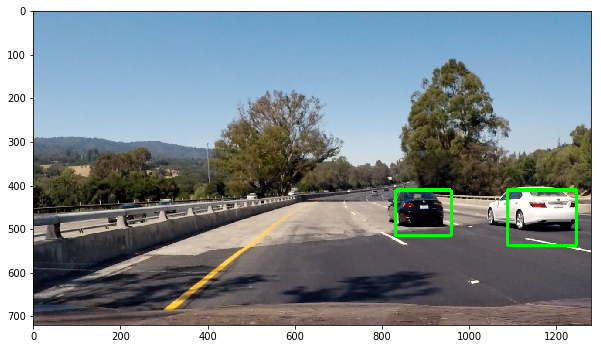

In [35]:
test_img = mpimg.imread('./test_images/test4.jpg')

draw_img = process_image(test_img)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

mpimg.imsave('./output_images/test_4.jpg', draw_img)

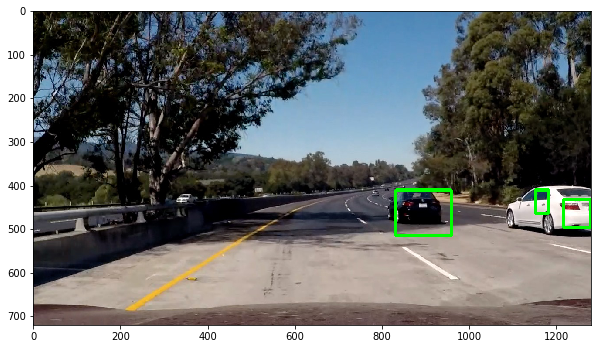

In [36]:
test_img = mpimg.imread('./test_images/test5.jpg')

draw_img = process_image(test_img)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

mpimg.imsave('./output_images/test_5.jpg', draw_img)

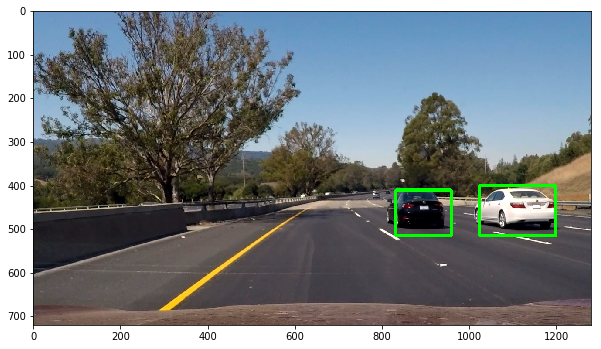

In [37]:
test_img = mpimg.imread('./test_images/test6.jpg')

draw_img = process_image(test_img)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

mpimg.imsave('./output_images/test_6.jpg', draw_img)

In [30]:

video_output1 = './test_videos_outputs/test_video_output.mp4'
video_input1 = VideoFileClip('./test_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video ./test_videos_outputs/test_video_output.mp4
[MoviePy] Writing video ./test_videos_outputs/test_video_output.mp4


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 38/39 [00:53<00:01,  1.48s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_outputs/test_video_output.mp4 

Wall time: 57.1 s


## Class to store data from video

In [31]:
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        self.prev_meas = []
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 16:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-16:]
  


## Pipeline for video

In [32]:
def process_video(img):
    
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    
    bxs = []   

    ystart = 400
    ystop = 520
    scale = 1.0


    bxs.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))

    ystart = 410
    ystop = 540
    scale = 1.0

    bxs.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))

   
    ystart = 420
    ystop = 520
    scale = 1.5

    bxs.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))


    ystart = 435
    ystop = 565
    scale = 1.5
    
     
    bxs.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))


    ystart = 400
    ystop = 520
    scale = 2

    bxs.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))


    ystart = 410
    ystop = 550
    scale = 2

    bxs.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))

    
    
    ystart = 430
    ystop = 670
    scale = 2.5

    bxs.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))

            
    ystart = 400
    ystop = 580
    scale = 3

    bxs.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))

            
    
    rectangles = [item for sublist in bxs for item in sublist] 
    
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
            
    
    heatmap_img = np.zeros_like(img[:,:,0])
    
    for rect_set in det.prev_rects:        
        heatmap_img = add_heat(heatmap_img, rect_set)            
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)

    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

## Run video on advanced pipeline

In [33]:
det = Vehicle_Detect()

video_output2 = './test_videos_outputs/test_video_output_2.mp4'
video_input2 = VideoFileClip('./test_video.mp4')
processed_video = video_input2.fl_image(process_video)
%time processed_video.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video ./test_videos_outputs/test_video_output_2.mp4
[MoviePy] Writing video ./test_videos_outputs/test_video_output_2.mp4


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 38/39 [00:50<00:01,  1.33s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_outputs/test_video_output_2.mp4 

Wall time: 53.6 s


## Project Video

In [34]:
det = Vehicle_Detect()

video_output3 = './test_videos_outputs/project_video_output.mp4'
video_input3 = VideoFileClip('./project_video.mp4')
processed_video = video_input3.fl_image(process_video)
%time processed_video.write_videofile(video_output3, audio=False)

[MoviePy] >>>> Building video ./test_videos_outputs/project_video_output.mp4
[MoviePy] Writing video ./test_videos_outputs/project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [27:26<00:01,  1.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_outputs/project_video_output.mp4 

Wall time: 27min 29s
